# Задача 4. Ансамбли

* **Дедлайн**: 05.04.2024, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- [x] Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- [x] При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- [x] * (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- [x] * (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

# Датасет

https://www.kaggle.com/competitions/playground-series-s4e2/data?select=train.csv

Возьмём данные пациентов, где необходимо классифицировать степень ожирения (или риск ожирения) 

Признаки: 
- id - id пациента
- Gender - пол
- Age - возраст
- Height - рост
- Weight - вес
- family_history_with_overweight - есть ли родственники с ожирением
- FAVC - часто ли употребляет высококалорийную пищу
- FCVC - частота употребления овощей
- NCP - полноценных приёмов пищи в день
- CAEC - ест ли дополнительно между полноценными приёмами пищи
- SMOKE - курильщик
- CH2O - потребление воды в день
- SCC - следит за употреблением калорий
- FAF - частота физических активностей
- TUE - время проводимое за гаджетами
- CALC - потребление алкоголя
- MTRANS - средство передвижения
- NObeyesdad - целевой признак, категория ожирения

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("obesity.csv")

In [2]:
df.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [3]:
df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [4]:
set(df["NObeyesdad"])

{'Insufficient_Weight',
 'Normal_Weight',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III',
 'Overweight_Level_I',
 'Overweight_Level_II'}

# Преобразуем данные 

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import scipy

# Преобразуем бинарные категориальные признаки
df["Gender"] = df["Gender"] == "Female"
df["family_history_with_overweight"] = df["family_history_with_overweight"] == "yes"
df["FAVC"] = df["FAVC"] == "yes"
df["SMOKE"] = df["SMOKE"] == "yes"
df["SCC"] = df["SCC"] == "yes"

# Преобразуем некоторые признаки так, чтобы категории можно было упорядочить
replacements_dict = {
    "NObeyesdad": {
        "Insufficient_Weight": 0,
        "Normal_Weight": 1,
        "Overweight_Level_I": 2,
        "Overweight_Level_II": 3,
        "Obesity_Type_I": 4,
        "Obesity_Type_II": 5,
        "Obesity_Type_III": 6,
    },
    "CALC": {"Frequently": 2, "Sometimes": 1, "no": 0},
    "CAEC": {'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0}
}

df["Walking_is_transport"] = df["MTRANS"] == "Walking" # Новый признак - предпочитает ходить пешком

# Закодируем виды транспорта
label_encoder = LabelEncoder()
df["MTRANS"] = label_encoder.fit_transform(df["MTRANS"])

NUM_CLASSES = 7 # Всего классов

df.replace(replacements_dict, inplace=True)

selected_features = [
    "Weight",
    "Age",
    "Height",
    "Gender",
    "family_history_with_overweight",
    "CALC",
    "FCVC",
    "FAVC",
    "NCP",
    "CAEC",
    "SMOKE",
    "CH2O",
    "SCC",
    "FAF",
    "TUE",
    "MTRANS",
    "Walking_is_transport"
]

X = np.array(df[selected_features])
Y = np.array(df["NObeyesdad"])

/tmp/ipykernel_332479/2051696604.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(replacements_dict, inplace=True)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

<Axes: >

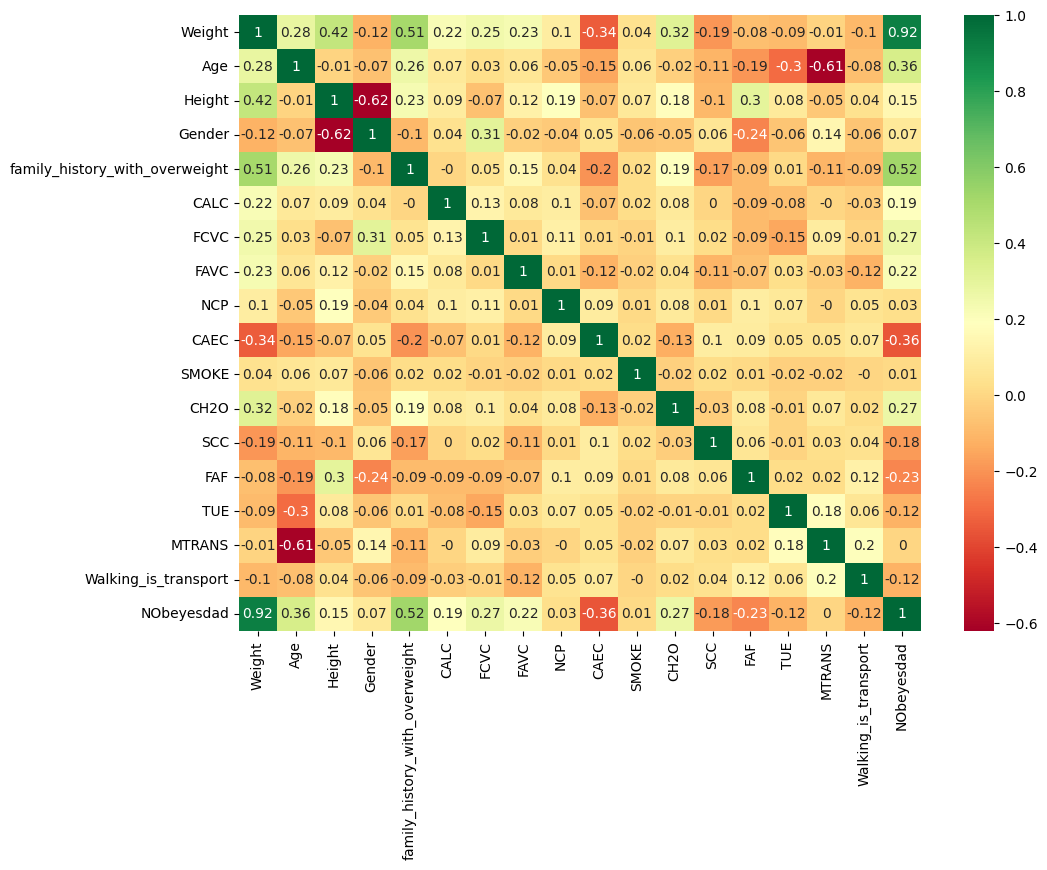

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

df_ = df[selected_features + ["NObeyesdad"]]

fig, ax = plt.subplots(figsize=(11, 8))
sns.heatmap(df_.corr().round(2), annot=True, cmap='RdYlGn', ax=ax)

Из данной матрицы видно, что степень ожирения сильно связана с весом человека, что ожидаемо, но при выставлении диагноза это, конечно, не единственный важный фактор. Также значительно влияет наличие родственников с ожирением, вероятно из-за наследственности или привычек питания в конкретной семье. Менее важными оказались: возраст, потребление еды между основными приемами пищи (что интересно зависимость отрицательная), потребление воды, употребление овощей, употребление калорийной пищи, рост, наличие спорта, наблюдение за калориями. При этом курение, пол и число полноценных приёмов пищи практически не влияют. Про влияение конкретного вид транспорта сложно сделать выводы, поскольку сложно осмысленно упорядочить их виды, но можно выделить в отдельный признак привычку ходить пешком и тогда видно небольшу отрицательную зависимость.  

# Имплементации Bagging и AdaBoost

In [8]:
from sklearn.base import BaseEstimator
from sklearn.base import clone

class MyBagging(BaseEstimator):
    def __init__(self, estimator=None, n_estimators=10, max_samples=1.0):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.estimators = [clone(estimator) for i in range(n_estimators)]

        if isinstance(max_samples, float): 
            assert 0.0 < max_samples <= 1.0, "max_samples as float must be in range (0, 1]"

    def fit(self, X, Y):
        draw_num_of_samples = int(X.shape[0] * self.max_samples)
        for estimator in self.estimators:
            ids = np.random.choice(range(len(Y)), min(len(Y), draw_num_of_samples))
            sub_X = X[ids]
            sub_Y = Y[ids]
            estimator.fit(sub_X, sub_Y)
    
    def predict(self, X):
        estimates = []
        for estimator in self.estimators:
            estimates.append(estimator.predict(X))
        
        estimates = np.array(estimates)

        return scipy.stats.mode(estimates).mode
    
    def score(self, X, Y):
        Y_pred = self.predict(X)
        accuracy = accuracy_score(Y, Y_pred)
        return accuracy


In [10]:
class MyAdaBoost(BaseEstimator):
    def __init__(self, estimator=None, n_estimators=10, learning_rate=1.0):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.estimators = [clone(estimator) for i in range(n_estimators)]
        self.learning_rate = learning_rate
        self.estimator_weights = []

    def fit(self, X, Y):
        weights = np.ones(len(Y)) * 1 / len(Y)
        for estimator in self.estimators:
            estimator.fit(X, Y, weights)
            predictions = estimator.predict(X)

            incorrect = predictions != Y
            err = np.sum(weights * incorrect) / np.sum(weights)
            if err <= 1e-15:
                self.estimator_weights.append(1)
                continue
 
            estimator_weight = self.learning_rate * (np.log((1.0 - err) / err) + np.log(NUM_CLASSES - 1))
            weights = weights * np.exp(estimator_weight * incorrect * (weights > 0))
            weights /= np.sum(weights)
            self.estimator_weights.append(estimator_weight)

    def predict(self, X):
        freq_table = np.zeros((NUM_CLASSES, len(X)))
        for num, estimator in enumerate(self.estimators):
            estim = estimator.predict(X)
            # print(estim)            
            for idx in range(len(X)):
                freq_table[estim[idx]][idx] += self.estimator_weights[num]

        return np.argmax(freq_table, axis=0)


    def score(self, X, Y):
        Y_pred = self.predict(X)
        return accuracy_score(Y, Y_pred)
        

# Применим Optuna

Для сравнения возьмем несколько моделей из sklearn, XGBoost, LightGDB и CatBoost. Воспользуемся optuna. В процессе выбора лучших гиперпараметров будем ориентироваться на accuracy. 
cv = 5

In [12]:
scores = dict()

In [26]:
import optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score

def evaluate_using_optuna(model, param_distributions, trials=40, n_jobs=-1):
    optuna_search = optuna.integration.OptunaSearchCV(
        model,
        param_distributions,
        n_trials=trials,
        n_jobs=n_jobs,
        cv=5,
    )
    optuna_search.fit(X_train, Y_train)
    best_estimator = optuna_search.best_estimator_
    Y_pred = best_estimator.predict(X_test)
    accuracy = round(accuracy_score(Y_test, Y_pred), 6)
    recall_macro = round(recall_score(Y_test, Y_pred, average='macro'), 6)
    precision_macro = round(precision_score(Y_test, Y_pred, average='macro'), 6)

    recall_weighted = round(recall_score(Y_test, Y_pred, average='weighted'), 6)
    precision_weighted  = round(precision_score(Y_test, Y_pred, average='weighted'), 6)

    metrics = {
        "accuracy": accuracy, 
        "precision_macro": precision_macro,
        "recall_macro": recall_macro, 
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        }

    return metrics 

In [27]:
my_bagging = MyBagging(DecisionTreeClassifier())
param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(1, 20),
    "max_samples": optuna.distributions.FloatDistribution(0, 1),
}

scores["MyBagging"] = evaluate_using_optuna(my_bagging, param_distributions)

/tmp/ipykernel_332479/3924960807.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-09-23 20:16:45,544] A new study created in memory with name: no-name-95feca0e-f38f-435f-8cfc-443c5b843272
[I 2024-09-23 20:17:39,723] Trial 0 finished with value: 0.8242811466846357 and parameters: {'n_estimators': 2, 'max_samples': 0.2754408091640621}. Best is trial 0 with value: 0.8242811466846357.
[I 2024-09-23 20:17:51,011] Trial 11 finished with value: 0.8331930369942538 and parameters: {'n_estimators': 2, 'max_samples': 0.46711287623573206}. Best is trial 11 with value: 0.8331930369942538.
[I 2024-09-23 20:18:01,825] Trial 18 finished with value: 0.826327961319616 and parameters: {'n_estimators': 2, 'max_samples': 0.296519386567929}. Best is trial 11 with value: 0.8331930369942538.
[I 2024-09-23 20:18:03,728] Trial 22 finished with value: 0.8406600146006811 and para

In [44]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(DecisionTreeClassifier())
param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(1, 20),
    "max_samples": optuna.distributions.FloatDistribution(0, 1),
}

scores["ScikitBagging"] = evaluate_using_optuna(bagging, param_distributions)

/tmp/ipykernel_332479/3924960807.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-09-24 16:55:02,487] A new study created in memory with name: no-name-f9dbd03b-1ebb-4a07-b3c6-3fb2bea96872
[I 2024-09-24 16:55:09,724] Trial 16 finished with value: 0.8337949389260432 and parameters: {'n_estimators': 1, 'max_samples': 0.4371605389059352}. Best is trial 16 with value: 0.8337949389260432.
[I 2024-09-24 16:55:10,116] Trial 11 finished with value: 0.8365647900241127 and parameters: {'n_estimators': 1, 'max_samples': 0.9610877551564637}. Best is trial 11 with value: 0.8365647900241127.
[I 2024-09-24 16:55:13,607] Trial 13 finished with value: 0.8340964700034318 and parameters: {'n_estimators': 2, 'max_samples': 0.6564787120354209}. Best is trial 11 with value: 0.8365647900241127.
[I 2024-09-24 16:55:16,743] Trial 9 finished with value: 0.8617367341644518 and pa

In [29]:
my_ada = MyAdaBoost(DecisionTreeClassifier())
param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(1, 20),
    "learning_rate": optuna.distributions.FloatDistribution(0, 2),
}

scores["MyAdaBoost"] = evaluate_using_optuna(my_ada, param_distributions)

/tmp/ipykernel_332479/3924960807.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-09-23 20:20:23,791] A new study created in memory with name: no-name-0e2b74ce-19cc-4c29-85f8-6c09d0d42ce4
[I 2024-09-23 20:20:37,453] Trial 14 finished with value: 0.8435506920458193 and parameters: {'n_estimators': 2, 'learning_rate': 0.17512410056857353}. Best is trial 14 with value: 0.8435506920458193.
[I 2024-09-23 20:20:43,422] Trial 15 finished with value: 0.8439119746070697 and parameters: {'n_estimators': 3, 'learning_rate': 0.7898409605982555}. Best is trial 15 with value: 0.8439119746070697.
[I 2024-09-23 20:20:53,671] Trial 5 finished with value: 0.8425871268546119 and parameters: {'n_estimators': 5, 'learning_rate': 0.739720957280176}. Best is trial 15 with value: 0.8439119746070697.
[I 2024-09-23 20:20:54,659] Trial 3 finished with value: 0.8426474221929992 a

In [42]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(), algorithm="SAMME")
param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(1, 20),
    "learning_rate": optuna.distributions.FloatDistribution(0, 2),
}

scores["ScikitAdaBoost"] = evaluate_using_optuna(ada, param_distributions)

/tmp/ipykernel_332479/3924960807.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-09-24 16:53:15,209] A new study created in memory with name: no-name-c339c70e-87b4-4659-9126-9f9d05099d1c
[I 2024-09-24 16:53:23,850] Trial 1 finished with value: 0.842286157760233 and parameters: {'n_estimators': 15, 'learning_rate': 1.1696287014482702}. Best is trial 1 with value: 0.842286157760233.
[I 2024-09-24 16:53:23,928] Trial 4 finished with value: 0.8423464168416519 and parameters: {'n_estimators': 4, 'learning_rate': 1.3876392064367178}. Best is trial 4 with value: 0.8423464168416519.
[I 2024-09-24 16:53:23,936] Trial 5 finished with value: 0.8427078806877439 and parameters: {'n_estimators': 20, 'learning_rate': 1.6346048131165527}. Best is trial 5 with value: 0.8427078806877439.
[I 2024-09-24 16:53:23,941] Trial 12 finished with value: 0.8407207450226887 and p

In [31]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(1, 200),
    "criterion": optuna.distributions.CategoricalDistribution(["gini", "entropy", "log_loss"]),
    "max_depth": optuna.distributions.CategoricalDistribution([None, 7, 13])
}

scores["ScikitRandomForest"] = evaluate_using_optuna(random_forest, param_distributions)


/tmp/ipykernel_332479/3924960807.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-09-23 20:22:29,477] A new study created in memory with name: no-name-21b1a21f-89c4-4daf-9a0b-dcdc19b4d78e
[I 2024-09-23 20:22:34,907] Trial 16 finished with value: 0.8571598901486374 and parameters: {'n_estimators': 5, 'criterion': 'gini', 'max_depth': None}. Best is trial 16 with value: 0.8571598901486374.
[I 2024-09-23 20:22:41,009] Trial 6 finished with value: 0.8612550784682373 and parameters: {'n_estimators': 19, 'criterion': 'log_loss', 'max_depth': 7}. Best is trial 6 with value: 0.8612550784682373.
[I 2024-09-23 20:22:41,143] Trial 13 finished with value: 0.8896184878632518 and parameters: {'n_estimators': 17, 'criterion': 'log_loss', 'max_depth': None}. Best is trial 13 with value: 0.8896184878632518.
[I 2024-09-23 20:22:43,420] Trial 27 finished with value: 0.86

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

random_forest = GradientBoostingClassifier()
param_distributions = {
    "learning_rate": optuna.distributions.FloatDistribution(1e-6, 1e-1, log=True),
    "n_estimators": optuna.distributions.IntDistribution(1, 200),
}

scores["ScikitGradientBoosting"] = evaluate_using_optuna(random_forest, param_distributions)


/tmp/ipykernel_332479/3924960807.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-09-23 20:23:52,941] A new study created in memory with name: no-name-d2c1b895-5fcc-4f25-9565-71db17b1cae7
[I 2024-09-23 20:24:00,972] Trial 13 finished with value: 0.19523064961066358 and parameters: {'learning_rate': 2.667532038628921e-06, 'n_estimators': 2}. Best is trial 13 with value: 0.19523064961066358.
[I 2024-09-23 20:24:04,282] Trial 20 finished with value: 0.19523064961066358 and parameters: {'learning_rate': 0.0011379569003473733, 'n_estimators': 3}. Best is trial 13 with value: 0.19523064961066358.
[I 2024-09-23 20:24:34,704] Trial 29 finished with value: 0.3371070854999138 and parameters: {'learning_rate': 0.005128485438568116, 'n_estimators': 9}. Best is trial 29 with value: 0.3371070854999138.
[I 2024-09-23 20:24:55,822] Trial 10 finished with value: 0.1952

In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_grad = HistGradientBoostingClassifier()
param_distributions = {
    "learning_rate": optuna.distributions.FloatDistribution(1e-6, 1e-1, log=True),
    "max_depth": optuna.distributions.CategoricalDistribution([None, 7, 13]),
}

scores["ScikitHistGradientBoosting"] = evaluate_using_optuna(hist_grad, param_distributions, n_jobs=1)


/tmp/ipykernel_332479/3924960807.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-09-23 20:31:32,964] A new study created in memory with name: no-name-d863c27b-2907-47a2-941f-9f28001e10b0
[I 2024-09-23 20:31:45,788] Trial 0 finished with value: 0.8937740984206284 and parameters: {'learning_rate': 0.009447063774425989, 'max_depth': None}. Best is trial 0 with value: 0.8937740984206284.
[I 2024-09-23 20:31:58,567] Trial 1 finished with value: 0.8972666596690718 and parameters: {'learning_rate': 0.013793041446455092, 'max_depth': 13}. Best is trial 1 with value: 0.8972666596690718.
[I 2024-09-23 20:32:10,355] Trial 2 finished with value: 0.19523064961066358 and parameters: {'learning_rate': 2.6010339823806576e-05, 'max_depth': 7}. Best is trial 1 with value: 0.8972666596690718.
[I 2024-09-23 20:32:23,048] Trial 3 finished with value: 0.8849215970251884 an

### Добавим XGBoost, LightGBM и CatBoost

In [21]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [22]:
xgb = XGBClassifier(random_state=42)
param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(1, 200),
    "max_depth": optuna.distributions.CategoricalDistribution([None, 7, 13]),
    "learning_rate": optuna.distributions.FloatDistribution(1e-6, 1e-1, log=True),
}

scores["XGBClassifier"] = evaluate_using_optuna(xgb, param_distributions, n_jobs=1)

/tmp/ipykernel_332479/1432688698.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-09-23 19:54:24,882] A new study created in memory with name: no-name-0450936b-9002-430e-b38e-c2082efe9cf8
[I 2024-09-23 19:54:29,127] Trial 0 finished with value: 0.8846204285174835 and parameters: {'n_estimators': 35, 'max_depth': 13, 'learning_rate': 1.5739985832238265e-06}. Best is trial 0 with value: 0.8846204285174835.
[I 2024-09-23 19:54:35,039] Trial 1 finished with value: 0.8845602056930328 and parameters: {'n_estimators': 139, 'max_depth': None, 'learning_rate': 0.009233663178394488}. Best is trial 0 with value: 0.8846204285174835.
[I 2024-09-23 19:54:41,813] Trial 2 finished with value: 0.8697462429169747 and parameters: {'n_estimators': 154, 'max_depth': None, 'learning_rate': 0.0002289474606860495}. Best is trial 0 with value: 0.8846204285174835.
[I 2024-09-23

In [23]:
lgbm = LGBMClassifier(random_state=42)
param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(1, 200),
    "max_depth": optuna.distributions.CategoricalDistribution([None, 7, 13]),
    "learning_rate": optuna.distributions.FloatDistribution(1e-6, 1e-1, log=True),
}

scores["LGBMClassifier"] = evaluate_using_optuna(lgbm, param_distributions, n_jobs=1)

/tmp/ipykernel_332479/1432688698.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-09-23 19:56:49,791] A new study created in memory with name: no-name-711cd2f2-ab16-43e9-b536-9428ce3bea5a


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[I 2024-09-23 19:56:52,973] Trial 0 finished with value: 0.9062394073000867 and parameters: {'n_estimators': 86, 'max_depth': None, 'learning_rate': 0.058055495065337415}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204

[I 2024-09-23 19:56:57,395] Trial 1 finished with value: 0.9058178837859019 and parameters: {'n_estimators': 126, 'max_depth': None, 'learning_rate': 0.03411100817475624}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 1328

[I 2024-09-23 19:57:00,358] Trial 2 finished with value: 0.19523064961066358 and parameters: {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 2.083937374196858e-06}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 1328

[I 2024-09-23 19:57:02,065] Trial 3 finished with value: 0.19523064961066358 and parameters: {'n_estimators': 47, 'max_depth': None, 'learning_rate': 0.00025679076421419357}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 1328

[I 2024-09-23 19:57:03,212] Trial 4 finished with value: 0.19523064961066358 and parameters: {'n_estimators': 30, 'max_depth': 13, 'learning_rate': 0.00015815929677848655}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 1328

[I 2024-09-23 19:57:05,789] Trial 5 finished with value: 0.19523064961066358 and parameters: {'n_estimators': 79, 'max_depth': 7, 'learning_rate': 0.00011305411020771923}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 1328

[I 2024-09-23 19:57:07,337] Trial 6 finished with value: 0.8911844625838057 and parameters: {'n_estimators': 47, 'max_depth': 7, 'learning_rate': 0.018088536461206763}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204

[I 2024-09-23 19:57:07,769] Trial 7 finished with value: 0.8829342982037754 and parameters: {'n_estimators': 10, 'max_depth': 7, 'learning_rate': 0.03577818890189649}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 13285, number of used features: 17
[LightGBM] [Info] Start training from score -2.117257
[LightGBM] [Info] Start training from score -1.911143
[LightGBM] [Info] Start training from score -2.145803
[LightGBM] [Info] Start training from score -2.112889
[LightGBM] [Info] Start training from score -1.947945
[LightGBM] [Info] Start training from score -1.857639
[LightGBM] [Info] Start training from score -1.633434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[I 2024-09-23 19:57:12,333] Trial 8 finished with value: 0.9059983891028957 and parameters: {'n_estimators': 152, 'max_depth': 7, 'learning_rate': 0.04588738162581296}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2024-09-23 19:57:17,718] Trial 9 finished with value: 0.9058175756016708 and parameters: {'n_estimators': 177, 'max_depth': 7, 'learning_rate': 0.05487542358098755}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204

[I 2024-09-23 19:57:21,760] Trial 10 finished with value: 0.8846807238558705 and parameters: {'n_estimators': 123, 'max_depth': None, 'learning_rate': 0.0021541340886349473}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204

[I 2024-09-23 19:57:27,314] Trial 11 finished with value: 0.891846931781245 and parameters: {'n_estimators': 168, 'max_depth': 13, 'learning_rate': 0.003281313882731794}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204

[I 2024-09-23 19:57:32,154] Trial 12 finished with value: 0.8919674499440827 and parameters: {'n_estimators': 145, 'max_depth': None, 'learning_rate': 0.004289031418836168}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204

[I 2024-09-23 19:57:34,655] Trial 13 finished with value: 0.19523064961066358 and parameters: {'n_estimators': 74, 'max_depth': None, 'learning_rate': 1.2353121425373869e-05}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 1328

[I 2024-09-23 19:57:41,150] Trial 14 finished with value: 0.8831150029340952 and parameters: {'n_estimators': 192, 'max_depth': 13, 'learning_rate': 0.001259551977916133}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204

[I 2024-09-23 19:57:44,492] Trial 15 finished with value: 0.8933524661355383 and parameters: {'n_estimators': 107, 'max_depth': 7, 'learning_rate': 0.009859486462007258}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2024-09-23 19:57:49,466] Trial 16 finished with value: 0.9046132460120507 and parameters: {'n_estimators': 148, 'max_depth': None, 'learning_rate': 0.0989292150671986}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-23 19:57:53,138] Trial 17 finished with value: 0.814585235691142 and parameters: {'n_estimators': 111, 'max_depth': None, 'learning_rate': 0.0008851750747279251}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204

[I 2024-09-23 19:57:57,707] Trial 18 finished with value: 0.8963030944778643 and parameters: {'n_estimators': 148, 'max_depth': 7, 'learning_rate': 0.009944336940132777}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 13284, number of used features: 17
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.911577
[LightGBM] [Info] Start training from score -2.145728
[LightGBM] [Info] Start training from score -2.112191
[LightGBM] [Info] Start training from score -1.948397
[LightGBM] [Info] Start training from score -1.857563
[LightGBM] [Info] Start training from score -1.633359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[I 2024-09-23 19:58:00,091] Trial 19 finished with value: 0.19523064961066358 and parameters: {'n_estimators': 70, 'max_depth': 13, 'learning_rate': 3.902567239284404e-05}. Best is trial 0 with value: 0.9062394073000867.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 17
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574


In [24]:
catboost = CatBoostClassifier(random_state=42)
param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(1, 200),
    "learning_rate": optuna.distributions.FloatDistribution(1e-6, 1e-1, log=True),
}

scores["CatBoostClassifier"] = evaluate_using_optuna(catboost, param_distributions, n_jobs=1)

/tmp/ipykernel_332479/1432688698.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2024-09-23 19:58:00,727] A new study created in memory with name: no-name-c7ecd7ec-b751-4ff6-8da7-95e8ce984de0


0:	learn: 1.9180177	total: 53.1ms	remaining: 10.3s
1:	learn: 1.8893520	total: 58.7ms	remaining: 5.66s
2:	learn: 1.8634921	total: 64ms	remaining: 4.1s
3:	learn: 1.8378255	total: 69.6ms	remaining: 3.32s
4:	learn: 1.8136561	total: 75ms	remaining: 2.85s
5:	learn: 1.7908623	total: 80.7ms	remaining: 2.54s
6:	learn: 1.7685002	total: 86.5ms	remaining: 2.32s
7:	learn: 1.7463603	total: 92.5ms	remaining: 2.16s
8:	learn: 1.7249406	total: 98.1ms	remaining: 2.03s
9:	learn: 1.7041912	total: 104ms	remaining: 1.93s
10:	learn: 1.6846743	total: 110ms	remaining: 1.85s
11:	learn: 1.6664825	total: 117ms	remaining: 1.79s
12:	learn: 1.6487558	total: 123ms	remaining: 1.72s
13:	learn: 1.6301555	total: 129ms	remaining: 1.66s
14:	learn: 1.6129123	total: 134ms	remaining: 1.61s
15:	learn: 1.5978112	total: 139ms	remaining: 1.56s
16:	learn: 1.5805965	total: 144ms	remaining: 1.51s
17:	learn: 1.5635029	total: 150ms	remaining: 1.48s
18:	learn: 1.5473418	total: 156ms	remaining: 1.44s
19:	learn: 1.5315360	total: 162ms	rem

[I 2024-09-23 19:58:09,234] Trial 0 finished with value: 0.8453574311647859 and parameters: {'n_estimators': 195, 'learning_rate': 0.008499004720669738}. Best is trial 0 with value: 0.8453574311647859.


193:	learn: 0.6279229	total: 1.65s	remaining: 8.51ms
194:	learn: 0.6261344	total: 1.66s	remaining: 0us
0:	learn: 1.9430502	total: 11.8ms	remaining: 1.23s
1:	learn: 1.9400038	total: 20.9ms	remaining: 1.08s
2:	learn: 1.9371431	total: 31.5ms	remaining: 1.07s
3:	learn: 1.9342030	total: 41.4ms	remaining: 1.04s
4:	learn: 1.9313570	total: 51.7ms	remaining: 1.03s
5:	learn: 1.9285766	total: 61.8ms	remaining: 1.02s
6:	learn: 1.9257103	total: 70.8ms	remaining: 992ms
7:	learn: 1.9228791	total: 79.9ms	remaining: 969ms
8:	learn: 1.9200254	total: 88.5ms	remaining: 944ms
9:	learn: 1.9171683	total: 97.6ms	remaining: 927ms
10:	learn: 1.9144222	total: 107ms	remaining: 915ms
11:	learn: 1.9117927	total: 116ms	remaining: 900ms
12:	learn: 1.9091534	total: 125ms	remaining: 886ms
13:	learn: 1.9063348	total: 135ms	remaining: 874ms
14:	learn: 1.9036741	total: 142ms	remaining: 855ms
15:	learn: 1.9012784	total: 152ms	remaining: 843ms
16:	learn: 1.8985107	total: 162ms	remaining: 840ms
17:	learn: 1.8957521	total: 17

[I 2024-09-23 19:58:14,221] Trial 1 finished with value: 0.7814039822116061 and parameters: {'n_estimators': 105, 'learning_rate': 0.0008681842377156921}. Best is trial 0 with value: 0.8453574311647859.


96:	learn: 1.7118957	total: 876ms	remaining: 72.2ms
97:	learn: 1.7098974	total: 883ms	remaining: 63.1ms
98:	learn: 1.7077836	total: 892ms	remaining: 54ms
99:	learn: 1.7058502	total: 900ms	remaining: 45ms
100:	learn: 1.7038130	total: 909ms	remaining: 36ms
101:	learn: 1.7017947	total: 917ms	remaining: 27ms
102:	learn: 1.6997391	total: 924ms	remaining: 17.9ms
103:	learn: 1.6977825	total: 934ms	remaining: 8.98ms
104:	learn: 1.6957899	total: 944ms	remaining: 0us
0:	learn: 1.9458914	total: 9.9ms	remaining: 1.3s
1:	learn: 1.9458713	total: 19.1ms	remaining: 1.24s
2:	learn: 1.9458524	total: 29.2ms	remaining: 1.26s
3:	learn: 1.9458329	total: 39.7ms	remaining: 1.27s
4:	learn: 1.9458139	total: 50.5ms	remaining: 1.28s
5:	learn: 1.9457953	total: 60.8ms	remaining: 1.28s
6:	learn: 1.9457760	total: 71ms	remaining: 1.27s
7:	learn: 1.9457568	total: 80.3ms	remaining: 1.24s
8:	learn: 1.9457375	total: 88.8ms	remaining: 1.21s
9:	learn: 1.9457180	total: 99.3ms	remaining: 1.21s
10:	learn: 1.9456992	total: 109m

[I 2024-09-23 19:58:20,424] Trial 2 finished with value: 0.777188728941273 and parameters: {'n_estimators': 132, 'learning_rate': 5.6922780019526536e-06}. Best is trial 0 with value: 0.8453574311647859.


117:	learn: 1.9436828	total: 1.04s	remaining: 124ms
118:	learn: 1.9436632	total: 1.05s	remaining: 115ms
119:	learn: 1.9436447	total: 1.06s	remaining: 106ms
120:	learn: 1.9436268	total: 1.07s	remaining: 97.1ms
121:	learn: 1.9436088	total: 1.08s	remaining: 88.2ms
122:	learn: 1.9435895	total: 1.08s	remaining: 79.4ms
123:	learn: 1.9435701	total: 1.09s	remaining: 70.5ms
124:	learn: 1.9435518	total: 1.1s	remaining: 61.7ms
125:	learn: 1.9435341	total: 1.11s	remaining: 52.8ms
126:	learn: 1.9435155	total: 1.12s	remaining: 44ms
127:	learn: 1.9434960	total: 1.13s	remaining: 35.2ms
128:	learn: 1.9434775	total: 1.13s	remaining: 26.4ms
129:	learn: 1.9434584	total: 1.14s	remaining: 17.6ms
130:	learn: 1.9434412	total: 1.15s	remaining: 8.79ms
131:	learn: 1.9434229	total: 1.16s	remaining: 0us
0:	learn: 1.6360963	total: 9.6ms	remaining: 1.24s
1:	learn: 1.4354061	total: 19.6ms	remaining: 1.26s
2:	learn: 1.2932391	total: 30.7ms	remaining: 1.3s
3:	learn: 1.1776155	total: 40.3ms	remaining: 1.27s
4:	learn: 1.

[I 2024-09-23 19:58:25,747] Trial 3 finished with value: 0.8972063643306847 and parameters: {'n_estimators': 130, 'learning_rate': 0.09937904312318842}. Best is trial 3 with value: 0.8972063643306847.


125:	learn: 0.2842157	total: 1.02s	remaining: 32.4ms
126:	learn: 0.2835545	total: 1.03s	remaining: 24.3ms
127:	learn: 0.2832577	total: 1.03s	remaining: 16.2ms
128:	learn: 0.2826742	total: 1.04s	remaining: 8.07ms
129:	learn: 0.2820735	total: 1.05s	remaining: 0us
0:	learn: 1.8875334	total: 9.9ms	remaining: 49.5ms
1:	learn: 1.8301117	total: 19ms	remaining: 38.1ms
2:	learn: 1.7806272	total: 28.2ms	remaining: 28.2ms
3:	learn: 1.7332812	total: 38.2ms	remaining: 19.1ms
4:	learn: 1.6898991	total: 48.3ms	remaining: 9.66ms
5:	learn: 1.6503067	total: 58ms	remaining: 0us
0:	learn: 1.8890343	total: 11.2ms	remaining: 55.8ms
1:	learn: 1.8320675	total: 21.8ms	remaining: 43.6ms
2:	learn: 1.7830933	total: 32.5ms	remaining: 32.5ms
3:	learn: 1.7358895	total: 42.8ms	remaining: 21.4ms
4:	learn: 1.6923008	total: 52.6ms	remaining: 10.5ms
5:	learn: 1.6528491	total: 61.7ms	remaining: 0us
0:	learn: 1.8881681	total: 11ms	remaining: 55.1ms
1:	learn: 1.8331943	total: 21.7ms	remaining: 43.4ms
2:	learn: 1.7836834	tot

[I 2024-09-23 19:58:26,431] Trial 4 finished with value: 0.7607484235923369 and parameters: {'n_estimators': 6, 'learning_rate': 0.017871677002226104}. Best is trial 3 with value: 0.8972063643306847.


0:	learn: 1.9455846	total: 9.59ms	remaining: 1.51s
1:	learn: 1.9452366	total: 20.7ms	remaining: 1.61s
2:	learn: 1.9449084	total: 30.7ms	remaining: 1.59s
3:	learn: 1.9445698	total: 40.3ms	remaining: 1.55s
4:	learn: 1.9442411	total: 49.2ms	remaining: 1.5s
5:	learn: 1.9439185	total: 58.6ms	remaining: 1.48s
6:	learn: 1.9435849	total: 69.2ms	remaining: 1.49s
7:	learn: 1.9432540	total: 79.3ms	remaining: 1.49s
8:	learn: 1.9429193	total: 88.2ms	remaining: 1.46s
9:	learn: 1.9425828	total: 96.4ms	remaining: 1.43s
10:	learn: 1.9422584	total: 105ms	remaining: 1.41s
11:	learn: 1.9419465	total: 115ms	remaining: 1.41s
12:	learn: 1.9416153	total: 124ms	remaining: 1.38s
13:	learn: 1.9412788	total: 132ms	remaining: 1.36s
14:	learn: 1.9409601	total: 140ms	remaining: 1.33s
15:	learn: 1.9406718	total: 147ms	remaining: 1.31s
16:	learn: 1.9403382	total: 156ms	remaining: 1.29s
17:	learn: 1.9400039	total: 165ms	remaining: 1.28s
18:	learn: 1.9396829	total: 174ms	remaining: 1.27s
19:	learn: 1.9393510	total: 183m

[I 2024-09-23 19:58:33,629] Trial 5 finished with value: 0.7779113847061944 and parameters: {'n_estimators': 158, 'learning_rate': 9.878662983198741e-05}. Best is trial 3 with value: 0.8972063643306847.


141:	learn: 1.9009152	total: 1.23s	remaining: 138ms
142:	learn: 1.9005901	total: 1.24s	remaining: 130ms
143:	learn: 1.9002903	total: 1.25s	remaining: 121ms
144:	learn: 1.8999916	total: 1.25s	remaining: 112ms
145:	learn: 1.8996806	total: 1.26s	remaining: 104ms
146:	learn: 1.8993659	total: 1.27s	remaining: 95ms
147:	learn: 1.8990596	total: 1.28s	remaining: 86.2ms
148:	learn: 1.8987444	total: 1.28s	remaining: 77.7ms
149:	learn: 1.8984452	total: 1.29s	remaining: 69.1ms
150:	learn: 1.8981320	total: 1.3s	remaining: 60.5ms
151:	learn: 1.8978334	total: 1.31s	remaining: 51.8ms
152:	learn: 1.8975423	total: 1.32s	remaining: 43.2ms
153:	learn: 1.8972368	total: 1.33s	remaining: 34.6ms
154:	learn: 1.8969434	total: 1.34s	remaining: 25.9ms
155:	learn: 1.8966317	total: 1.35s	remaining: 17.3ms
156:	learn: 1.8963319	total: 1.36s	remaining: 8.65ms
157:	learn: 1.8960181	total: 1.37s	remaining: 0us
0:	learn: 1.7201645	total: 11.3ms	remaining: 1.88s
1:	learn: 1.5628909	total: 21.6ms	remaining: 1.78s
2:	learn

[I 2024-09-23 19:58:40,400] Trial 6 finished with value: 0.8961222628481552 and parameters: {'n_estimators': 167, 'learning_rate': 0.07116532431391463}. Best is trial 3 with value: 0.8972063643306847.


158:	learn: 0.2942759	total: 1.28s	remaining: 64.5ms
159:	learn: 0.2939081	total: 1.29s	remaining: 56.3ms
160:	learn: 0.2934115	total: 1.29s	remaining: 48.2ms
161:	learn: 0.2929572	total: 1.3s	remaining: 40.1ms
162:	learn: 0.2923244	total: 1.31s	remaining: 32.1ms
163:	learn: 0.2918194	total: 1.31s	remaining: 24.1ms
164:	learn: 0.2911730	total: 1.32s	remaining: 16ms
165:	learn: 0.2906441	total: 1.33s	remaining: 8.01ms
166:	learn: 0.2902199	total: 1.34s	remaining: 0us
0:	learn: 1.9435367	total: 10.5ms	remaining: 336ms
1:	learn: 1.9410067	total: 21ms	remaining: 325ms
2:	learn: 1.9386290	total: 31.7ms	remaining: 317ms
3:	learn: 1.9361836	total: 42.5ms	remaining: 308ms
4:	learn: 1.9338151	total: 52.7ms	remaining: 295ms
5:	learn: 1.9314993	total: 63.2ms	remaining: 284ms
6:	learn: 1.9291103	total: 73.6ms	remaining: 273ms
7:	learn: 1.9267489	total: 82.3ms	remaining: 257ms
8:	learn: 1.9243671	total: 90ms	remaining: 240ms
9:	learn: 1.9219806	total: 98.3ms	remaining: 226ms
10:	learn: 1.9196854	to

[I 2024-09-23 19:58:42,343] Trial 7 finished with value: 0.7766469773199972 and parameters: {'n_estimators': 33, 'learning_rate': 0.0007204559108560895}. Best is trial 3 with value: 0.8972063643306847.


25:	learn: 1.8862581	total: 232ms	remaining: 62.4ms
26:	learn: 1.8840611	total: 242ms	remaining: 53.7ms
27:	learn: 1.8818392	total: 250ms	remaining: 44.7ms
28:	learn: 1.8797116	total: 260ms	remaining: 35.8ms
29:	learn: 1.8774821	total: 268ms	remaining: 26.8ms
30:	learn: 1.8753727	total: 278ms	remaining: 17.9ms
31:	learn: 1.8732223	total: 287ms	remaining: 8.97ms
32:	learn: 1.8710889	total: 298ms	remaining: 0us
0:	learn: 1.8429737	total: 10.5ms	remaining: 994ms
1:	learn: 1.7568563	total: 20.5ms	remaining: 962ms
2:	learn: 1.6793794	total: 30.5ms	remaining: 945ms
3:	learn: 1.6080376	total: 40.4ms	remaining: 930ms
4:	learn: 1.5439330	total: 49.4ms	remaining: 899ms
5:	learn: 1.4883860	total: 59.9ms	remaining: 898ms
6:	learn: 1.4365351	total: 69.4ms	remaining: 883ms
7:	learn: 1.3881848	total: 78.1ms	remaining: 859ms
8:	learn: 1.3414753	total: 86ms	remaining: 832ms
9:	learn: 1.2997382	total: 95.5ms	remaining: 821ms
10:	learn: 1.2613207	total: 105ms	remaining: 812ms
11:	learn: 1.2279147	total: 

[I 2024-09-23 19:58:46,826] Trial 8 finished with value: 0.8676387341169551 and parameters: {'n_estimators': 96, 'learning_rate': 0.031741120133396465}. Best is trial 3 with value: 0.8972063643306847.


69:	learn: 0.5333815	total: 614ms	remaining: 228ms
70:	learn: 0.5298196	total: 621ms	remaining: 219ms
71:	learn: 0.5255944	total: 627ms	remaining: 209ms
72:	learn: 0.5222408	total: 633ms	remaining: 200ms
73:	learn: 0.5184290	total: 639ms	remaining: 190ms
74:	learn: 0.5150794	total: 646ms	remaining: 181ms
75:	learn: 0.5119801	total: 652ms	remaining: 172ms
76:	learn: 0.5086416	total: 658ms	remaining: 162ms
77:	learn: 0.5056277	total: 664ms	remaining: 153ms
78:	learn: 0.5020402	total: 670ms	remaining: 144ms
79:	learn: 0.4997022	total: 677ms	remaining: 135ms
80:	learn: 0.4970636	total: 683ms	remaining: 126ms
81:	learn: 0.4941862	total: 689ms	remaining: 118ms
82:	learn: 0.4919320	total: 695ms	remaining: 109ms
83:	learn: 0.4885265	total: 701ms	remaining: 100ms
84:	learn: 0.4857183	total: 706ms	remaining: 91.4ms
85:	learn: 0.4830258	total: 712ms	remaining: 82.8ms
86:	learn: 0.4805358	total: 718ms	remaining: 74.3ms
87:	learn: 0.4781685	total: 724ms	remaining: 65.8ms
88:	learn: 0.4759494	total:

[I 2024-09-23 19:58:51,903] Trial 9 finished with value: 0.8000120554419805 and parameters: {'n_estimators': 104, 'learning_rate': 0.005350112030680194}. Best is trial 3 with value: 0.8972063643306847.


100:	learn: 1.0919053	total: 906ms	remaining: 26.9ms
101:	learn: 1.0875611	total: 914ms	remaining: 17.9ms
102:	learn: 1.0833304	total: 923ms	remaining: 8.96ms
103:	learn: 1.0792363	total: 932ms	remaining: 0us
0:	learn: 1.9459003	total: 10.7ms	remaining: 727ms
1:	learn: 1.9458897	total: 21.8ms	remaining: 730ms
2:	learn: 1.9458797	total: 31.7ms	remaining: 697ms
3:	learn: 1.9458694	total: 42.3ms	remaining: 688ms
4:	learn: 1.9458594	total: 51.3ms	remaining: 657ms
5:	learn: 1.9458496	total: 61.1ms	remaining: 641ms
6:	learn: 1.9458394	total: 70.9ms	remaining: 628ms
7:	learn: 1.9458293	total: 80.5ms	remaining: 614ms
8:	learn: 1.9458191	total: 89.4ms	remaining: 596ms
9:	learn: 1.9458089	total: 99ms	remaining: 584ms
10:	learn: 1.9457990	total: 108ms	remaining: 569ms
11:	learn: 1.9457894	total: 117ms	remaining: 557ms
12:	learn: 1.9457793	total: 127ms	remaining: 548ms
13:	learn: 1.9457690	total: 135ms	remaining: 531ms
14:	learn: 1.9457593	total: 143ms	remaining: 516ms
15:	learn: 1.9457505	total: 

[I 2024-09-23 19:58:55,371] Trial 10 finished with value: 0.7762252543924865 and parameters: {'n_estimators': 69, 'learning_rate': 3.0007223481859272e-06}. Best is trial 3 with value: 0.8972063643306847.


44:	learn: 1.9454630	total: 416ms	remaining: 222ms
45:	learn: 1.9454529	total: 423ms	remaining: 212ms
46:	learn: 1.9454429	total: 430ms	remaining: 201ms
47:	learn: 1.9454327	total: 436ms	remaining: 191ms
48:	learn: 1.9454227	total: 442ms	remaining: 180ms
49:	learn: 1.9454129	total: 449ms	remaining: 171ms
50:	learn: 1.9454027	total: 456ms	remaining: 161ms
51:	learn: 1.9453923	total: 462ms	remaining: 151ms
52:	learn: 1.9453824	total: 468ms	remaining: 141ms
53:	learn: 1.9453728	total: 475ms	remaining: 132ms
54:	learn: 1.9453629	total: 481ms	remaining: 122ms
55:	learn: 1.9453527	total: 488ms	remaining: 113ms
56:	learn: 1.9453427	total: 494ms	remaining: 104ms
57:	learn: 1.9453326	total: 502ms	remaining: 95.2ms
58:	learn: 1.9453225	total: 508ms	remaining: 86.1ms
59:	learn: 1.9453124	total: 514ms	remaining: 77.1ms
60:	learn: 1.9453024	total: 520ms	remaining: 68.3ms
61:	learn: 1.9452924	total: 527ms	remaining: 59.5ms
62:	learn: 1.9452823	total: 533ms	remaining: 50.8ms
63:	learn: 1.9452725	tota

[I 2024-09-23 19:59:02,511] Trial 11 finished with value: 0.8981698207509868 and parameters: {'n_estimators': 168, 'learning_rate': 0.09866341310234038}. Best is trial 11 with value: 0.8981698207509868.


161:	learn: 0.2654534	total: 1.25s	remaining: 46.3ms
162:	learn: 0.2648607	total: 1.26s	remaining: 38.6ms
163:	learn: 0.2645524	total: 1.27s	remaining: 30.9ms
164:	learn: 0.2642433	total: 1.27s	remaining: 23.1ms
165:	learn: 0.2639159	total: 1.28s	remaining: 15.4ms
166:	learn: 0.2635448	total: 1.29s	remaining: 7.71ms
167:	learn: 0.2630415	total: 1.29s	remaining: 0us
0:	learn: 1.7404583	total: 11.1ms	remaining: 1.67s
1:	learn: 1.5928886	total: 21.9ms	remaining: 1.63s
2:	learn: 1.4741957	total: 32.8ms	remaining: 1.62s
3:	learn: 1.3676377	total: 42.3ms	remaining: 1.55s
4:	learn: 1.2798903	total: 52.8ms	remaining: 1.54s
5:	learn: 1.2082914	total: 62.4ms	remaining: 1.51s
6:	learn: 1.1439770	total: 72.5ms	remaining: 1.49s
7:	learn: 1.0859103	total: 81.9ms	remaining: 1.46s
8:	learn: 1.0324587	total: 91.7ms	remaining: 1.45s
9:	learn: 0.9849733	total: 102ms	remaining: 1.44s
10:	learn: 0.9462318	total: 111ms	remaining: 1.41s
11:	learn: 0.9097424	total: 119ms	remaining: 1.38s
12:	learn: 0.8762425	

[I 2024-09-23 19:59:08,596] Trial 12 finished with value: 0.8942556997313902 and parameters: {'n_estimators': 151, 'learning_rate': 0.06451562484952603}. Best is trial 11 with value: 0.8981698207509868.


133:	learn: 0.3182045	total: 1.02s	remaining: 130ms
134:	learn: 0.3171902	total: 1.03s	remaining: 122ms
135:	learn: 0.3165948	total: 1.03s	remaining: 114ms
136:	learn: 0.3159897	total: 1.04s	remaining: 106ms
137:	learn: 0.3154586	total: 1.05s	remaining: 98.7ms
138:	learn: 0.3149903	total: 1.05s	remaining: 91ms
139:	learn: 0.3143768	total: 1.06s	remaining: 83.4ms
140:	learn: 0.3137360	total: 1.07s	remaining: 75.8ms
141:	learn: 0.3131934	total: 1.08s	remaining: 68.2ms
142:	learn: 0.3122436	total: 1.08s	remaining: 60.6ms
143:	learn: 0.3116823	total: 1.09s	remaining: 53ms
144:	learn: 0.3111291	total: 1.1s	remaining: 45.5ms
145:	learn: 0.3104637	total: 1.1s	remaining: 37.9ms
146:	learn: 0.3099476	total: 1.11s	remaining: 30.3ms
147:	learn: 0.3092970	total: 1.12s	remaining: 22.7ms
148:	learn: 0.3086953	total: 1.13s	remaining: 15.2ms
149:	learn: 0.3080730	total: 1.14s	remaining: 7.58ms
150:	learn: 0.3076722	total: 1.15s	remaining: 0us
0:	learn: 1.9457624	total: 10.9ms	remaining: 2.08s
1:	learn

[I 2024-09-23 19:59:16,026] Trial 13 finished with value: 0.7777306618473905 and parameters: {'n_estimators': 191, 'learning_rate': 4.4820039245096594e-05}. Best is trial 11 with value: 0.8981698207509868.


177:	learn: 1.9199259	total: 1.3s	remaining: 94.8ms
178:	learn: 1.9197870	total: 1.3s	remaining: 87.5ms
179:	learn: 1.9196443	total: 1.31s	remaining: 80.1ms
180:	learn: 1.9194980	total: 1.32s	remaining: 72.8ms
181:	learn: 1.9193488	total: 1.32s	remaining: 65.5ms
182:	learn: 1.9192010	total: 1.33s	remaining: 58.2ms
183:	learn: 1.9190569	total: 1.34s	remaining: 50.9ms
184:	learn: 1.9189217	total: 1.34s	remaining: 43.6ms
185:	learn: 1.9187742	total: 1.35s	remaining: 36.3ms
186:	learn: 1.9186338	total: 1.36s	remaining: 29ms
187:	learn: 1.9184917	total: 1.36s	remaining: 21.7ms
188:	learn: 1.9183489	total: 1.37s	remaining: 14.5ms
189:	learn: 1.9182074	total: 1.37s	remaining: 7.24ms
190:	learn: 1.9180628	total: 1.38s	remaining: 0us
0:	learn: 1.9387577	total: 9.93ms	remaining: 1.3s
1:	learn: 1.9311853	total: 19.5ms	remaining: 1.26s
2:	learn: 1.9241245	total: 28.7ms	remaining: 1.23s
3:	learn: 1.9169136	total: 38.2ms	remaining: 1.22s
4:	learn: 1.9099691	total: 46.4ms	remaining: 1.18s
5:	learn: 1

[I 2024-09-23 19:59:22,158] Trial 14 finished with value: 0.7898348694504403 and parameters: {'n_estimators': 132, 'learning_rate': 0.002172652842426329}. Best is trial 11 with value: 0.8981698207509868.


120:	learn: 1.3894231	total: 1.07s	remaining: 97ms
121:	learn: 1.3865174	total: 1.07s	remaining: 88.2ms
122:	learn: 1.3834108	total: 1.08s	remaining: 79.3ms
123:	learn: 1.3803319	total: 1.09s	remaining: 70.5ms
124:	learn: 1.3775039	total: 1.1s	remaining: 61.8ms
125:	learn: 1.3746797	total: 1.11s	remaining: 52.9ms
126:	learn: 1.3717790	total: 1.12s	remaining: 44.1ms
127:	learn: 1.3687498	total: 1.13s	remaining: 35.3ms
128:	learn: 1.3658855	total: 1.14s	remaining: 26.5ms
129:	learn: 1.3630519	total: 1.15s	remaining: 17.6ms
130:	learn: 1.3603815	total: 1.15s	remaining: 8.8ms
131:	learn: 1.3575996	total: 1.16s	remaining: 0us
0:	learn: 1.6444779	total: 9.74ms	remaining: 1.29s
1:	learn: 1.4467829	total: 20ms	remaining: 1.31s
2:	learn: 1.3058766	total: 30.7ms	remaining: 1.33s
3:	learn: 1.1908082	total: 40.1ms	remaining: 1.29s
4:	learn: 1.0981203	total: 49ms	remaining: 1.25s
5:	learn: 1.0243231	total: 57.4ms	remaining: 1.21s
6:	learn: 0.9593961	total: 66.9ms	remaining: 1.2s
7:	learn: 0.9009165

[I 2024-09-23 19:59:27,810] Trial 15 finished with value: 0.8972665871551351 and parameters: {'n_estimators': 133, 'learning_rate': 0.09651410492333413}. Best is trial 11 with value: 0.8981698207509868.


113:	learn: 0.2954518	total: 944ms	remaining: 157ms
114:	learn: 0.2948268	total: 952ms	remaining: 149ms
115:	learn: 0.2943271	total: 960ms	remaining: 141ms
116:	learn: 0.2935834	total: 968ms	remaining: 132ms
117:	learn: 0.2927830	total: 975ms	remaining: 124ms
118:	learn: 0.2921540	total: 982ms	remaining: 116ms
119:	learn: 0.2915033	total: 989ms	remaining: 107ms
120:	learn: 0.2904167	total: 996ms	remaining: 98.7ms
121:	learn: 0.2895435	total: 1s	remaining: 90.5ms
122:	learn: 0.2888179	total: 1.01s	remaining: 82.2ms
123:	learn: 0.2882180	total: 1.02s	remaining: 74ms
124:	learn: 0.2876017	total: 1.03s	remaining: 65.8ms
125:	learn: 0.2870491	total: 1.03s	remaining: 57.5ms
126:	learn: 0.2864126	total: 1.04s	remaining: 49.3ms
127:	learn: 0.2860959	total: 1.05s	remaining: 41ms
128:	learn: 0.2855612	total: 1.06s	remaining: 32.8ms
129:	learn: 0.2850743	total: 1.06s	remaining: 24.6ms
130:	learn: 0.2846238	total: 1.07s	remaining: 16.4ms
131:	learn: 0.2839952	total: 1.08s	remaining: 8.18ms
132:	le

[I 2024-09-23 19:59:35,940] Trial 16 finished with value: 0.8403593536905334 and parameters: {'n_estimators': 175, 'learning_rate': 0.008106938991809656}. Best is trial 11 with value: 0.8981698207509868.


170:	learn: 0.6913688	total: 1.45s	remaining: 33.8ms
171:	learn: 0.6892021	total: 1.45s	remaining: 25.4ms
172:	learn: 0.6868284	total: 1.46s	remaining: 16.9ms
173:	learn: 0.6847219	total: 1.47s	remaining: 8.46ms
174:	learn: 0.6826172	total: 1.48s	remaining: 0us
0:	learn: 1.9452598	total: 11.3ms	remaining: 813ms
1:	learn: 1.9445648	total: 21.4ms	remaining: 760ms
2:	learn: 1.9439098	total: 32.6ms	remaining: 760ms
3:	learn: 1.9432344	total: 42.7ms	remaining: 736ms
4:	learn: 1.9425788	total: 52.5ms	remaining: 714ms
5:	learn: 1.9419360	total: 62.6ms	remaining: 700ms
6:	learn: 1.9412714	total: 73ms	remaining: 688ms
7:	learn: 1.9406126	total: 83ms	remaining: 674ms
8:	learn: 1.9399465	total: 91.9ms	remaining: 653ms
9:	learn: 1.9392771	total: 99.4ms	remaining: 626ms
10:	learn: 1.9386321	total: 107ms	remaining: 602ms
11:	learn: 1.9380124	total: 113ms	remaining: 576ms
12:	learn: 1.9373546	total: 120ms	remaining: 553ms
13:	learn: 1.9366864	total: 126ms	remaining: 532ms
14:	learn: 1.9360539	total: 

[I 2024-09-23 19:59:39,376] Trial 17 finished with value: 0.7766469410630289 and parameters: {'n_estimators': 73, 'learning_rate': 0.00019736998611351116}. Best is trial 11 with value: 0.8981698207509868.


53:	learn: 1.9114399	total: 476ms	remaining: 168ms
54:	learn: 1.9108243	total: 484ms	remaining: 158ms
55:	learn: 1.9101847	total: 493ms	remaining: 150ms
56:	learn: 1.9095585	total: 500ms	remaining: 140ms
57:	learn: 1.9089334	total: 508ms	remaining: 131ms
58:	learn: 1.9083001	total: 516ms	remaining: 122ms
59:	learn: 1.9076699	total: 525ms	remaining: 114ms
60:	learn: 1.9070534	total: 533ms	remaining: 105ms
61:	learn: 1.9064274	total: 542ms	remaining: 96.2ms
62:	learn: 1.9058008	total: 551ms	remaining: 87.4ms
63:	learn: 1.9051991	total: 559ms	remaining: 78.6ms
64:	learn: 1.9045965	total: 567ms	remaining: 69.8ms
65:	learn: 1.9039824	total: 574ms	remaining: 60.9ms
66:	learn: 1.9033589	total: 582ms	remaining: 52.1ms
67:	learn: 1.9027508	total: 589ms	remaining: 43.3ms
68:	learn: 1.9021263	total: 596ms	remaining: 34.6ms
69:	learn: 1.9014954	total: 604ms	remaining: 25.9ms
70:	learn: 1.9008648	total: 612ms	remaining: 17.2ms
71:	learn: 1.9002644	total: 622ms	remaining: 8.63ms
72:	learn: 1.8996349

[I 2024-09-23 19:59:45,640] Trial 18 finished with value: 0.7767069463456693 and parameters: {'n_estimators': 138, 'learning_rate': 2.485840176648205e-05}. Best is trial 11 with value: 0.8981698207509868.


127:	learn: 1.9354303	total: 1.02s	remaining: 79.7ms
128:	learn: 1.9353506	total: 1.03s	remaining: 71.7ms
129:	learn: 1.9352680	total: 1.04s	remaining: 63.8ms
130:	learn: 1.9351937	total: 1.05s	remaining: 55.9ms
131:	learn: 1.9351151	total: 1.05s	remaining: 48ms
132:	learn: 1.9350367	total: 1.06s	remaining: 40ms
133:	learn: 1.9349588	total: 1.07s	remaining: 32.1ms
134:	learn: 1.9348772	total: 1.08s	remaining: 24ms
135:	learn: 1.9347984	total: 1.09s	remaining: 16ms
136:	learn: 1.9347174	total: 1.1s	remaining: 8.03ms
137:	learn: 1.9346337	total: 1.11s	remaining: 0us
0:	learn: 1.9390172	total: 10.8ms	remaining: 1.9s
1:	learn: 1.9317170	total: 20.7ms	remaining: 1.82s
2:	learn: 1.9249070	total: 31.6ms	remaining: 1.84s
3:	learn: 1.9179496	total: 42.8ms	remaining: 1.86s
4:	learn: 1.9112472	total: 52.3ms	remaining: 1.81s
5:	learn: 1.9047408	total: 62.8ms	remaining: 1.8s
6:	learn: 1.8980692	total: 72.8ms	remaining: 1.78s
7:	learn: 1.8915189	total: 81.4ms	remaining: 1.73s
8:	learn: 1.8849502	tot

[I 2024-09-23 19:59:53,148] Trial 19 finished with value: 0.792544950936164 and parameters: {'n_estimators': 178, 'learning_rate': 0.0020937293267794805}. Best is trial 11 with value: 0.8981698207509868.


0:	learn: 1.6387665	total: 11.9ms	remaining: 1.98s
1:	learn: 1.4453146	total: 22.8ms	remaining: 1.9s
2:	learn: 1.3016197	total: 33.9ms	remaining: 1.86s
3:	learn: 1.1815547	total: 44.2ms	remaining: 1.81s
4:	learn: 1.0924091	total: 53.9ms	remaining: 1.75s
5:	learn: 1.0165969	total: 63.7ms	remaining: 1.72s
6:	learn: 0.9456680	total: 73.7ms	remaining: 1.7s
7:	learn: 0.8903625	total: 83.4ms	remaining: 1.67s
8:	learn: 0.8388076	total: 92.6ms	remaining: 1.64s
9:	learn: 0.7961105	total: 102ms	remaining: 1.61s
10:	learn: 0.7610558	total: 111ms	remaining: 1.58s
11:	learn: 0.7301132	total: 119ms	remaining: 1.54s
12:	learn: 0.6978450	total: 126ms	remaining: 1.5s
13:	learn: 0.6703401	total: 135ms	remaining: 1.49s
14:	learn: 0.6432873	total: 144ms	remaining: 1.47s
15:	learn: 0.6209332	total: 152ms	remaining: 1.44s
16:	learn: 0.6008114	total: 159ms	remaining: 1.41s
17:	learn: 0.5833576	total: 167ms	remaining: 1.39s
18:	learn: 0.5667182	total: 174ms	remaining: 1.36s
19:	learn: 0.5504488	total: 181ms	r

# Результаты

In [45]:
pd.DataFrame(scores).T

,accuracy,precision_macro,recall_macro,precision_weighted,recall_weighted
MyBagging,0.887765,0.876123,0.876353,0.888543,0.887765
ScikitBagging,0.889692,0.878068,0.878110,0.890167,0.889692
MyAdaBoost,0.847784,0.832102,0.832451,0.848213,0.847784
ScikitAdaBoost,0.845617,0.830395,0.830091,0.846374,0.845617
ScikitRandomForest,0.896917,0.887037,0.885027,0.897398,0.896917
ScikitGradientBoosting,0.904624,0.894481,0.893939,0.904641,0.904624
ScikitHistGradientBoosting,0.901734,0.891719,0.890587,0.902083,0.901734
XGBClassifier,0.907996,0.898688,0.897578,0.908490,0.907996
LGBMClassifier,0.903420,0.893498,0.892715,0.903704,0.903420
CatBoostClassifier,0.902216,0.891605,0.891920,0.902373,0.902216


Как можно увидеть, полученные реализации дают сопоставимое качество с их аналогами из scikit. Но при этом они медленнее учатся (из-за того, что библиотека значительно лучше оптимизирована). 
Также можно увидеть, что градиентный бустинг обходит другие методы, а adaboost показывает наихудшие результаты среди использованных методов.